In [1]:
import pandas as pd
import numpy as np 
from pandarallel import pandarallel

In [2]:
import sklearn

In [3]:
pandarallel.initialize()


INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Examination and Preparation #

In [4]:
dataset = pd.read_csv('GTEX_data.csv')

In [41]:
dataset.head()

,Unnamed: 0,A1BG,A2LD1,A2M,A2ML1,A4GALT,AAAS,AACS,AAED1,AAGAB,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,tissue
0,GTEX-1117F,0.738055,-0.177512,-2.565279,1.182233,-0.090569,-2.314897,-0.468852,0.760869,0.270284,...,0.572460,-2.077009,-0.081923,-1.613992,-0.618748,-1.798076,2.565279,2.565279,-2.204469,Adipose_Subcutaneous
1,GTEX-111CU,0.623972,0.212631,-0.699026,0.328851,0.623972,0.217038,0.743722,0.337958,0.704535,...,-0.522425,0.306203,-0.960567,1.053534,-0.221450,-1.016737,0.760869,1.016737,-0.488170,Adipose_Subcutaneous
2,GTEX-111FC,0.517495,-0.552281,0.177512,0.270284,0.507671,0.426007,-1.217622,-0.778242,-1.038647,...,1.303395,0.517495,0.572460,-0.230286,0.557304,0.068965,-0.151318,-1.190940,1.190940,Adipose_Subcutaneous
3,GTEX-111VG,1.539381,0.881575,0.738055,1.009542,-0.370057,0.416593,-0.837945,-0.473665,0.454478,...,0.567394,1.798076,-1.798076,-2.702943,-0.913795,-1.264124,2.204469,0.974322,-1.680894,Adipose_Subcutaneous
4,GTEX-111YS,-1.068659,-0.056019,0.077602,1.131768,-0.507671,-1.053534,0.920353,-0.407217,0.212631,...,-0.430727,0.274754,-0.693537,-0.047394,1.031289,0.248014,-1.472472,0.981268,-0.203828,Adipose_Subcutaneous


In [42]:
dataset.shape

(15201, 12559)

In [5]:
dataset_sorted_id = dataset.sort_values(by=['Unnamed: 0'])

Dataset is sorted so that the test and training set won't have the same person's entries in each, in order to prevent data leakage. 

Note that this method is not perfect and will allow one person's entries to appear in both test and training set. 

In [5]:
dataset_sorted_id.isnull().sum().sum()

0

No NANs in dataset. 


In [44]:
small = dataset.sample(10000)
#sample a section of the dataset if desired

In [31]:
def stratified_split(dataframe, test_size, random_state=42):
    """This function splits the dataframe specified into a train set and a test set. The split proportion is determined by
    the specified test_size. A stratified split (stratified by tissue) is performed and it is ensured that no patient appears
    in both the test and train split (to ensure independence)
    
    It is very slow to run.
    """
    from sklearn.model_selection import StratifiedShuffleSplit

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(dataframe, dataframe["tissue"]):
            strat_train_set_full = dataframe.iloc[train_index]
            strat_test_set = dataframe.iloc[test_index]
            
    for patient in dataframe["Unnamed: 0"].unique():
        if patient in strat_train_set_full['Unnamed: 0'].values and patient in strat_test_set['Unnamed: 0'].values:
            len_train = strat_train_set_full['Unnamed: 0'].value_counts()[patient]
            len_test = strat_test_set['Unnamed: 0'].value_counts()[patient]
            if len_train > 0 and len_test > 0:
                if len_test > len_train:
                    rows = strat_train_set_full.loc[lambda strat_train_set_full: strat_train_set_full['Unnamed: 0'] == patient]
                    strat_test_set = strat_test_set.append(rows, ignore_index=True)
                    strat_train_set_full.drop(rows.index, inplace=True)
                else:
                    rows = strat_test_set.loc[lambda strat_test_set: strat_test_set['Unnamed: 0'] == patient]
                    strat_train_set_full = strat_train_set_full.append(rows, ignore_index=True)
                    strat_test_set.drop(rows.index, inplace=True)
                    
    return strat_train_set_full, strat_test_set

In [ ]:
train, test = stratified_split(dataset, 0.3)
#slow to run. too slow

In [ ]:
#need to speed the above up + create validation set + make into X and y

In [6]:
#non stratified split method

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

X = dataset_sorted_id.drop(["Unnamed: 0", "tissue"], axis=1)
target = dataset_sorted_id["tissue"]

#label encode targets
le = LabelEncoder()
y = le.fit_transform(target)


X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, shuffle=False)


#scale all features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [40]:
X_val_scaled.shape

(2037, 12557)

In [7]:
number_classes = len(le.classes_)
number_classes

49

# Model Exploration #

## Random Forest ##

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_jobs=-1, verbose=3)

In [ ]:
rf.fit(X_train_scaled, y_train)

In [ ]:
rf.score(X_train_scaled, y_train)

Can fit to training set. Poor result on test set -> overfitting. Can examine with hyperparameter tuning later.  

In [ ]:
rf.score(X_test_scaled, y_test)

Result is 0.4

### Hyperparameter tuning ###

In [17]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [22]:
parameter_grid = {

  'n_estimators': sp_randint(200,600),
  'max_depth':  sp_randint(20,110),
}

In [24]:
rnd_search = RandomForestClassifier(n_jobs=-1, verbose=3)
random_search_rf = RandomizedSearchCV(rnd_search, parameter_grid, cv=KFold(n_splits=3, shuffle=False), random_state=42, verbose=3, n_iter=5)

random_search_rf.fit(X_train_scaled,y_train)

result = pd.concat([pd.DataFrame(random_search_rf.cv_results_["params"]),pd.DataFrame(random_search_rf.cv_results_["mean_test_score"], columns=["Score"])],axis=1)
result.sort_values(by="Score", ascending=False, inplace=True)

result

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_estimators=548, max_depth=71 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:  2.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 548 out of 548 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] ...... n_estimators=548, max_depth=71, score=0.578, total= 2.6min
[CV] n_estimators=548, max_depth=71 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed:    0.5s
[Parallel(n_jobs=16)]: Done 548 out of 548 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.6min remaining:    0.0s


[CV] ...... n_estimators=548, max_depth=71, score=0.578, total= 2.1min
[CV] n_estimators=548, max_depth=71 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:  2.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 548 out of 548 | elapsed:    0.4s finished


[CV] ...... n_estimators=548, max_depth=71, score=0.578, total= 2.8min
[CV] n_estimators=306, max_depth=34 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 306 out of 306 | elapsed:    0.4s finished


[CV] ...... n_estimators=306, max_depth=34, score=0.545, total= 1.6min
[CV] n_estimators=306, max_depth=34 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 306 out of 306 | elapsed:    0.3s finished


[CV] ...... n_estimators=306, max_depth=34, score=0.543, total= 1.5min
[CV] n_estimators=306, max_depth=34 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 306 out of 306 | elapsed:    0.2s finished


[CV] ...... n_estimators=306, max_depth=34, score=0.530, total= 1.6min
[CV] n_estimators=388, max_depth=91 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:  1.6min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 388 out of 388 | elapsed:    0.4s finished


[CV] ...... n_estimators=388, max_depth=91, score=0.557, total= 1.8min
[CV] n_estimators=388, max_depth=91 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:  1.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 388 out of 388 | elapsed:    0.4s finished


[CV] ...... n_estimators=388, max_depth=91, score=0.561, total= 2.1min
[CV] n_estimators=388, max_depth=91 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 388 out of 388 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 388 out of 388 | elapsed:    0.4s finished


[CV] ...... n_estimators=388, max_depth=91, score=0.562, total= 2.1min
[CV] n_estimators=302, max_depth=40 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:  1.3min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 302 out of 302 | elapsed:    0.3s finished


[CV] ...... n_estimators=302, max_depth=40, score=0.551, total= 1.6min
[CV] n_estimators=302, max_depth=40 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:  1.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 302 out of 302 | elapsed:    0.3s finished


[CV] ...... n_estimators=302, max_depth=40, score=0.545, total= 1.5min
[CV] n_estimators=302, max_depth=40 ..................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 302 out of 302 | elapsed:  1.4min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 302 out of 302 | elapsed:    0.3s finished


[CV] ...... n_estimators=302, max_depth=40, score=0.541, total= 1.7min
[CV] n_estimators=414, max_depth=102 .................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 414 out of 414 | elapsed:    0.5s finished


[CV] ..... n_estimators=414, max_depth=102, score=0.565, total= 2.1min
[CV] n_estimators=414, max_depth=102 .................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:  1.8min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 414 out of 414 | elapsed:    0.5s finished


[CV] ..... n_estimators=414, max_depth=102, score=0.564, total= 2.0min
[CV] n_estimators=414, max_depth=102 .................................


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 414 out of 414 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 414 out of 414 | elapsed:    0.4s finished


[CV] ..... n_estimators=414, max_depth=102, score=0.560, total= 2.2min


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 29.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 548building tree 2 of 548
building tree 3 of 548
building tree 4 of 548building tree 5 of 548
building tree 6 of 548
building tree 7 of 548
building tree 8 of 548
building tree 9 of 548
building tree 10 of 548
building tree 11 of 548

building tree 12 of 548building tree 13 of 548building tree 14 of 548



building tree 15 of 548building tree 16 of 548

building tree 17 of 548
building tree 18 of 548
building tree 19 of 548
building tree 20 of 548
building tree 21 of 548
building tree 22 of 548
building tree 23 of 548
building tree 24 of 548
building tree 25 of 548
building tree 26 of 548
building tree 27 of 548
building tree 28 of 548
building tree 29 of 548
building tree 30 of 548
building tree 31 of 548
building tree 32 of 548
building tree 33 of 548
building tree 34 of 548
building tree 35 of 548
building tree 36 of 548
building tree 37 of 548
building tree 38 of 548
building tree 39 of 548
building tree 40 of 548
building tree 41 of 548
building tree 42 of 548
b

[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   37.6s


building tree 113 of 548
building tree 114 of 548
building tree 115 of 548
building tree 116 of 548
building tree 117 of 548
building tree 118 of 548
building tree 119 of 548
building tree 120 of 548
building tree 121 of 548
building tree 122 of 548
building tree 123 of 548
building tree 124 of 548
building tree 125 of 548
building tree 126 of 548
building tree 127 of 548
building tree 128 of 548
building tree 129 of 548
building tree 130 of 548
building tree 131 of 548
building tree 132 of 548
building tree 133 of 548
building tree 134 of 548
building tree 135 of 548
building tree 136 of 548
building tree 137 of 548
building tree 138 of 548
building tree 139 of 548
building tree 140 of 548
building tree 141 of 548
building tree 142 of 548
building tree 143 of 548
building tree 144 of 548
building tree 145 of 548
building tree 146 of 548building tree 147 of 548
building tree 148 of 548

building tree 149 of 548
building tree 150 of 548
building tree 151 of 548
building tree 152 of 548


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.6min


building tree 273 of 548
building tree 274 of 548
building tree 275 of 548
building tree 276 of 548
building tree 277 of 548
building tree 278 of 548
building tree 279 of 548
building tree 280 of 548
building tree 281 of 548
building tree 282 of 548
building tree 283 of 548
building tree 284 of 548
building tree 285 of 548
building tree 286 of 548
building tree 287 of 548
building tree 288 of 548
building tree 289 of 548
building tree 290 of 548
building tree 291 of 548
building tree 292 of 548
building tree 293 of 548
building tree 294 of 548
building tree 295 of 548building tree 296 of 548

building tree 297 of 548
building tree 298 of 548
building tree 299 of 548
building tree 300 of 548
building tree 301 of 548
building tree 302 of 548
building tree 303 of 548
building tree 304 of 548
building tree 305 of 548
building tree 306 of 548
building tree 307 of 548
building tree 308 of 548
building tree 309 of 548
building tree 310 of 548
building tree 311 of 548
building tree 312 of 548


[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:  2.9min


building tree 496 of 548
building tree 497 of 548
building tree 498 of 548
building tree 499 of 548
building tree 500 of 548
building tree 501 of 548
building tree 502 of 548
building tree 503 of 548
building tree 504 of 548
building tree 505 of 548
building tree 506 of 548
building tree 507 of 548
building tree 508 of 548
building tree 509 of 548
building tree 510 of 548
building tree 511 of 548
building tree 512 of 548
building tree 513 of 548
building tree 514 of 548
building tree 515 of 548
building tree 516 of 548
building tree 517 of 548
building tree 518 of 548
building tree 519 of 548
building tree 520 of 548
building tree 521 of 548
building tree 522 of 548
building tree 523 of 548
building tree 524 of 548
building tree 525 of 548
building tree 526 of 548
building tree 527 of 548
building tree 528 of 548
building tree 529 of 548
building tree 530 of 548
building tree 531 of 548
building tree 532 of 548
building tree 533 of 548
building tree 534 of 548
building tree 535 of 548


[Parallel(n_jobs=-1)]: Done 548 out of 548 | elapsed:  3.3min finished


,max_depth,n_estimators,Score
0,71,548,0.578004
4,102,414,0.563029
2,91,388,0.559961
3,40,302,0.545599
1,34,306,0.539707


Best score is around 0.57. So RF can overfit well, but struggling to generalise. Would need more estimators for a better score but it doesn't look to be as promising as the NN. Why? I thought RF should be comparable given it is tabular data? 

## Neural network ##

In [8]:
import tensorflow as tf
from tensorflow import keras 

In [9]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
tf.__version__


'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

### Test implementation ###

Only testing on one validation set is not robust right? You could do some sort of cross validation where you select different validation folds, but then training is just longer. I guess it depends on the size of the validation fold. But what is done in practice?

In [11]:

X_valid, X_train = X_val_scaled, X_train_scaled
y_valid, y_train = y_val, y_train

In [12]:
model = keras.models.Sequential([
    keras.layers.Dense(1000, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(500, activation="relu"),
    keras.layers.Dense(number_classes, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

#callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Train on 8147 samples, validate on 2037 samples
Epoch 1/100
8147/8147 [==============================] - 16s 2ms/sample - loss: 2.5306 - accuracy: 0.4026 - val_loss: 1.6465 - val_accuracy: 0.6122
Epoch 2/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.8607 - accuracy: 0.8171 - val_loss: 1.1563 - val_accuracy: 0.7177
Epoch 3/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.3593 - accuracy: 0.9440 - val_loss: 0.9329 - val_accuracy: 0.7658
Epoch 4/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.1682 - accuracy: 0.9872 - val_loss: 0.8491 - val_accuracy: 0.7865
Epoch 5/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0916 - accuracy: 0.9985 - val_loss: 0.7840 - val_accuracy: 0.7982
Epoch 6/100
8147/8147 [==============================] - 12s 1ms/sample - loss: 0.0590 - accuracy: 0.9999 - val_loss: 0.7654 - val_accuracy: 0.7963
Epoch 7/100
8147/8147 [==============================] - 12s 1ms

Epoch 56/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.6221 - val_accuracy: 0.8321
Epoch 57/100
8147/8147 [==============================] - 10s 1ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.6225 - val_accuracy: 0.8321
Epoch 58/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6215 - val_accuracy: 0.8331
Epoch 59/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6214 - val_accuracy: 0.8326
Epoch 60/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.6213 - val_accuracy: 0.8331
Epoch 61/100
8147/8147 [==============================] - 11s 1ms/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.6206 - val_accuracy: 0.8336
Epoch 62/100
8147/8147 [==============================] - 10s 1ms/sample - loss: 0.0023 - accuracy: 1.0000

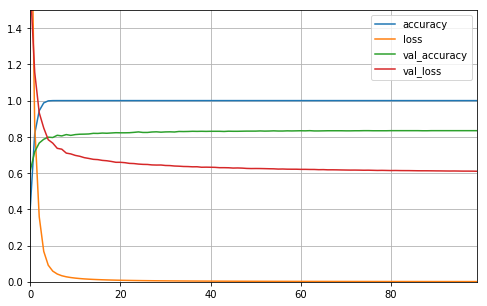

In [15]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1.5)
plt.show()

In [25]:
model.evaluate(X_test_scaled, y_test)

5017/5017 [==============================] - 3s 567us/sample - loss: 1.3500 - accuracy: 0.7172


[1.3499739765051662, 0.71716166]

In [ ]:
##sample##

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

predictions = model(x_train[:1]).numpy()


tf.nn.softmax(predictions).numpy()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_fn(y_train[:1], predictions).numpy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)


In [48]:
tf.config.experimental.list_physical_devices('GPU')

[]